# Note to self:

## draw histogram of each output for QLKNN and target to compare

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
import glob

In [2]:
from QLKNN import QLKNN, QLKNN_Dataset, train_keys, target_keys

/tmp/ipykernel_35021/1374400934.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


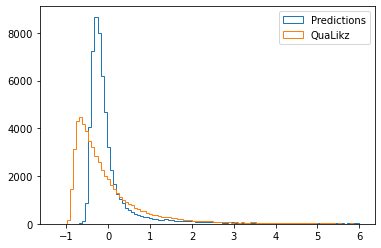

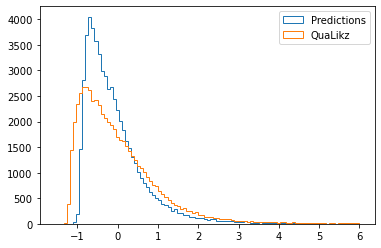

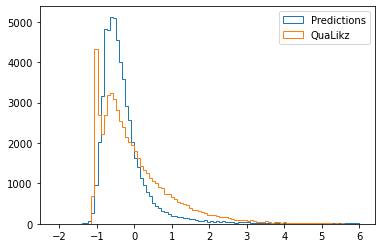

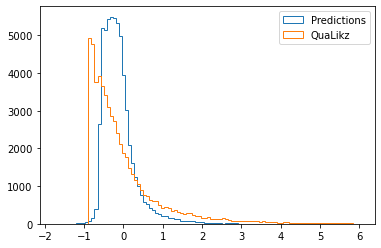

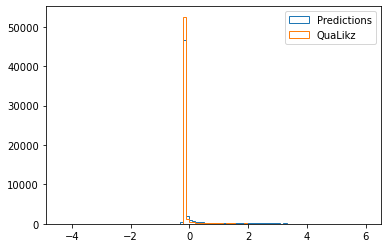

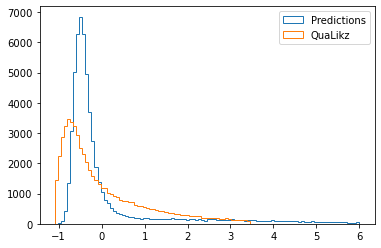

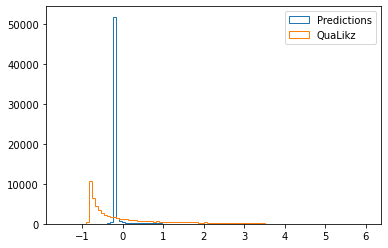

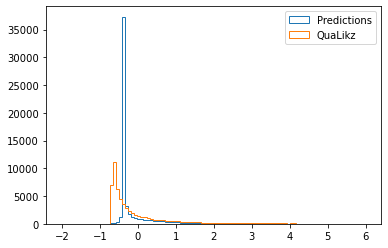

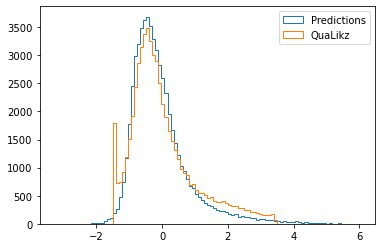

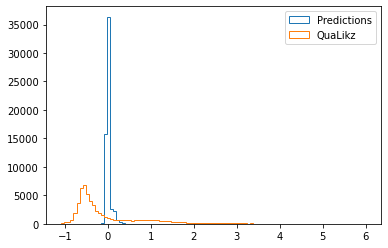

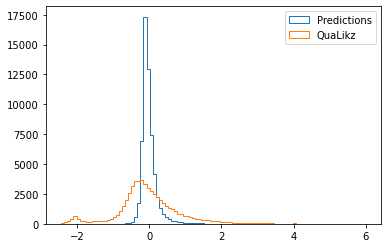

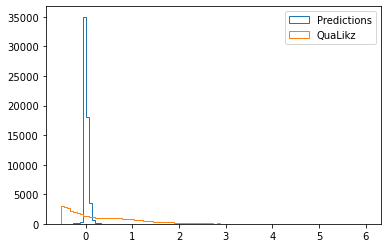

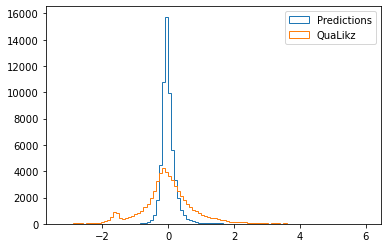

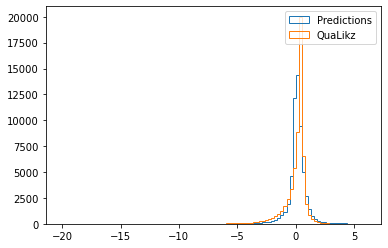

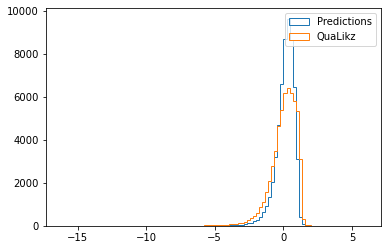

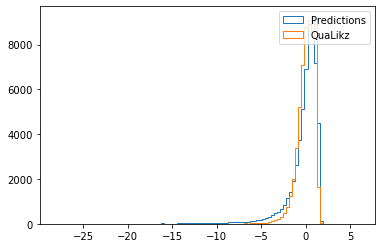

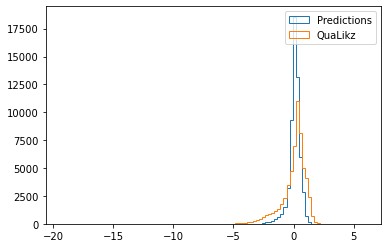

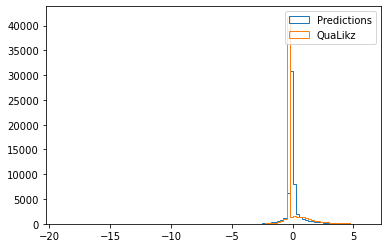

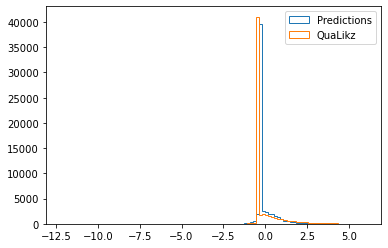

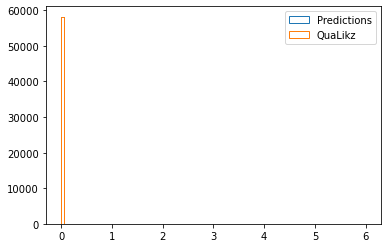

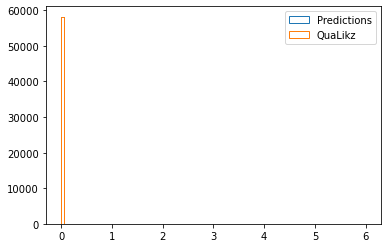

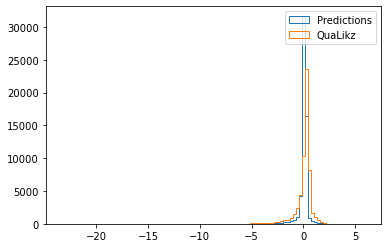

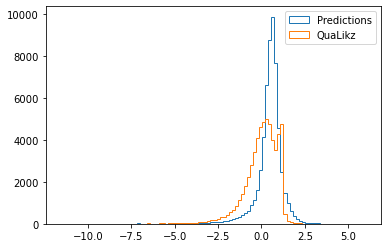

In [14]:
test_data_path = "data/QLKNN_test_data.pkl"
test_data = QLKNN_Dataset(test_data_path)

scaler = StandardScaler()
test_data.data = scaler.fit_transform(test_data.data)
test_data.data = pd.DataFrame(test_data.data, columns = train_keys + target_keys)

for target in target_keys:
    path = glob.glob(f"logs/QLKNN-Regressor/{target}/*.ckpt")[0]
    model = QLKNN.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 25, learning_rate = 0.001)

    tested = test_data.data[train_keys + [target]]

    test_loader = DataLoader(tested, batch_size = 2048, shuffle = True, num_workers = 1)
    
    y = test_data.data[target]
    y = torch.tensor(y.values)
    X = test_data.data[train_keys]
    X = torch.tensor(X.values)
    
    predictions = model(X).detach().numpy()
    
    
    plt.figure()
    
    plt.hist(predictions, bins = 100, histtype = 'step',
             label = "Predictions", range = (predictions.min(), 6))
    plt.hist(test_data.data[target], bins = 100, histtype = 'step',
             label = "QuaLikz", range = (predictions.min(), 6))
    plt.legend()

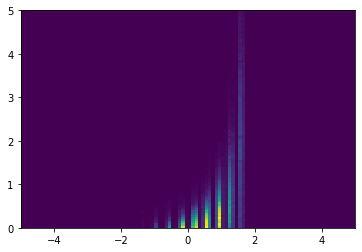

In [77]:
plt.figure()

x = test_data.data[train_keys[5]]
y = test_data.data[target]

x_range = [x.min(), x.mean() + 3*x.std()]
y_range = [y.mean(), y.mean() + 2*y.std()]

plt.hist2d(test_data.data[train_keys[6]], test_data.data[target], range = [x_range, y_range], bins = 100);

In [13]:
predictions_numpy = predictions.squeeze().detach().numpy()

random_variable = test_data.data[train_keys[3]].to_numpy()

predictions_dict = {'x': random_variable, 'y': predictions_numpy}
predictions_df = pd.DataFrame(data = predictions_dict)
predictions_df['type'] = 'QLKNN'

target_dict = {'x': random_variable, 'y': test_data.data[target]}
target_df = pd.DataFrame(data = target_dict)
target_df['type'] = 'target'

plot_df = pd.concat([predictions_df.sample(5_000), target_df.sample(5_000)], axis = 0, ignore_index = True)

plot_df

,x,y,type
0,-0.527808,-0.346224,QLKNN
1,-0.527808,0.229583,QLKNN
2,-0.527808,-0.010027,QLKNN
3,1.179245,-0.076614,QLKNN
4,-0.527808,0.042413,QLKNN
...,...,...,...
9995,-0.527808,-0.381980,target
9996,-0.527808,0.278875,target
9997,-0.527808,0.216100,target
9998,1.938282,-0.131613,target


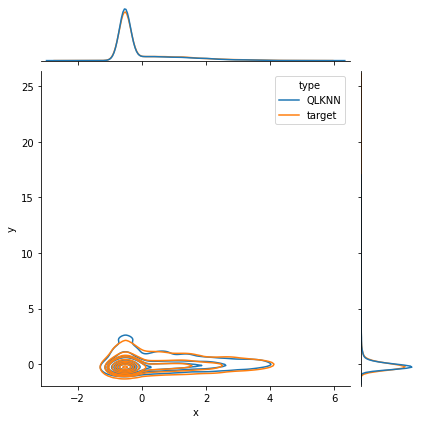

In [16]:
sns.jointplot(data = plot_df, x = 'x', y = 'y', hue = 'type', kind = 'kde')

In [ ]:
trainer = Trainer()

trainer.test(model = model, dataloaders = test_loader)